# Information Retreival  

Created by : FrancoisHUP
Last update : 20 dec 2023

We are doing indexation on TREC AP 88-90 documents and querying the system with 150 requests.
Then we check the MAP score. 

0. Utils
1. Config env
2. Data loading
3. Tokenization
4. Indexing
5. Search
6. Evaluation 

It create an index for each tokenisation methode.  

### Get documents 

In [70]:
import glob
import gzip
import re

doc_pattern = re.compile(r'<DOC>(.*?)</DOC>', re.DOTALL)
docno_pattern = re.compile(r'<DOCNO>\s*(.*?)\s*</DOCNO>')
head_pattern = re.compile(r'<HEAD>\s*(.*?)\s*</HEAD>')
text_pattern = re.compile(r'<TEXT>\s*(.*?)\s*</TEXT>', re.DOTALL)

def get_documents() :
    documents = []
    # Get a list of all .gz files in the "Ap" directory
    file_list = glob.glob('TREC AP 88-90/TREC AP 88-90/collection de documents/AP/*.gz') # start from ../src

    # Loop over the list of files
    for filename in file_list:
        
        # Open the .gz file
        with gzip.open(filename, 'rt', encoding='latin1') as file:  # 'rt' mode for text reading
            # Read the contents of the file
            content = file.read()
            for doc in doc_pattern.finditer(content):
                doc_content = doc.group(1)

                # Extracting individual elements
                doc_id = docno_pattern.search(doc_content).group(1)
                head = head_pattern.search(doc_content)
                text = text_pattern.search(doc_content)
                
                documents.append([doc_id, head.group(1) if head else '',text.group(1) if text else ''])

    return documents

documents = get_documents()
print(documents[0]) 

['AP880212-0001', 'Reports Former Saigon Officials Released from Re-education Camp', "More than 150 former officers of the\noverthrown South Vietnamese government have been released from a\nre-education camp after 13 years of detention, the official Vietnam\nNews Agency reported Saturday.\n   The report from Hanoi, monitored in Bangkok, did not give\nspecific figures, but said those freed Friday included an\nex-Cabinet minister, a deputy minister, 10 generals, 115\nfield-grade officers and 25 chaplains.\n   It quoted Col. Luu Van Ham, director of the Nam Ha camp south of\nHanoi, as saying all 700 former South Vietnamese officials who had\nbeen held at the camp now have been released.\n   They were among 1,014 South Vietnamese who were to be released\nfrom re-education camps under an amnesty announced by the Communist\ngovernment to mark Tet, the lunar new year that begins Feb. 17.\n   The Vietnam News Agency report said many foreign journalists and\na delegation from the Australia-Viet

### LUCENE

In [1]:
import lucene
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.analysis.en import EnglishAnalyzer
from org.apache.lucene.document import Document, Field, StringField, TextField
from org.apache.lucene.index import IndexWriter, IndexWriterConfig
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.store import MMapDirectory
from java.nio.file import Paths
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.queryparser.classic import QueryParser


In [2]:
lucene.initVM()

In [3]:
# analyzer = StandardAnalyzer()
analyzer = EnglishAnalyzer()
index = MMapDirectory(Paths.get("indexStemming"))  # specify a directory path
config = IndexWriterConfig(analyzer)
writer = IndexWriter(index, config)

In [22]:
for document in documents:
    doc = Document()
    doc.add(StringField("doc_id", document[0], Field.Store.YES))  # Add your custom doc ID
    doc.add(TextField("content", document[1] + document[2], Field.Store.YES))
    writer.addDocument(doc)
writer.close()

In [12]:
print(documents[1]) 

['AP880212-0002', 'Iowa Caucus Results Shake Up New Hampshire Race', "The ripples from the Iowa precinct caucuses are\nspreading to New Hampshire, boosting winners and damaging losers in\nthe final days before the nation's first primary, polls indicate.\n   Vice President George Bush, who was slipping in New Hampshire\neven before his third-place Iowa finish, lost more ground in polls\nthis week. Democratic third-place finisher Michael Dukakis also\nlost support, but not as much.\n   Iowa, meanwhile, has boosted the candidacies of Rep. Richard\nGephardt of Missouri and Sen. Bob Dole of Kansas, the Democratic\nand Republican winners, and has aided Pat Robertson, Iowa's\nsurprise second-place Republican finisher, the polls indicate.\n   As recently as two weeks ago, Bush commanded the New Hampshire\nGOP field. A CBS News-New York Times poll in the last week of\nJanuary had him 22 percentage points over Dole, the same place he'd\nheld in polls since November and earlier.\n   But a crack a

In [54]:
reader = DirectoryReader.open(index)
searcher = IndexSearcher(reader)
query = QueryParser("content", analyzer).parse("Antitrust Cases Pending Document discusses a pending antitrust case.")
hits = searcher.search(query, 1000).scoreDocs


### Analyse a search

In [ ]:
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.analysis.en import EnglishAnalyzer
from org.apache.lucene.analysis import TokenStream
from org.apache.lucene.analysis.tokenattributes import CharTermAttribute

# Sample text to tokenize
text = """
Firstar Corp. and Banks of Iowa Inc. said
Monday they had agreed to merge in a stock swap valued at about
$200 million.
   The companies said it would be the first interstate merger
agreement in Iowa since that state approved an interstate banking
law earlier this year.
   The agreement calls for Firstar, which is an $8.5 billion bank
holding company based in Milwaukee, to exchange 2.7 of its shares
for each outstanding share of the common stock of Banks of Iowa, a
$2.5 billion bank holding company based in Des Moines.
   Based on the closing price of Firstar stock Friday on the New
York Stock Exchange, Banks of Iowa shareholders would receive a
Firstar stock with a value of about $75.60 per share or a total of
$219.1 million.
   The Iowa company would become Firstar Corp. of Iowa upon
completion of the transaction, and the combined organization would
have 52 banks and 174 offices in Wisconsin, Iowa, Minnesota,
Illinois and Arizona, as well as a trust subsidiary in Florida.
   The agreement is subject to, among other things, approval by the
shareholders of both companies and state and federal banking
authorities.
   The merger ``benefits Firstar by moving us into the growing
urban areas of Iowa, which enjoy healthy diversified economies. It
benefits Banks of Iowa by adding major new resources for its
customers and operations,'' said Firstar Chairman John H. Hendee Jr.
   Banks of Iowa Chairman Holmes Foster said James R. Lang would
become president and chief executive of Firstar Corp. of Iowa upon
the closing of the transaction, which is expected in the first half
of 1991.
   Iowa's interstate banking law does not go into effect until Jan.
1.
   Lang is now president of the First Wisconsin National Bank of
Madison. Foster, 63, is to retire upon completion of the
transaction.
   The agreement calls for two members of the Banks of Iowa board
to be added to the Firstar board, bringing the total number of
Firstar directors to 22.
   The transaction grants Firstar an option to purchase newly
issued shares of Banks of Iowa common stock in an amount equal to
24.9 percent of Banks of Iowa's current outstanding shares.
"""


# Create a StandardAnalyzer instance (or use any other analyzer)
analyzer = EnglishAnalyzer()

# Tokenize the text
tokenStream = analyzer.tokenStream(None, text)
tokenStream.reset()

# Open a file to write the tokens
with open('tokenise_english.txt', 'w') as file:
    while tokenStream.incrementToken():
        token = tokenStream.getAttribute(CharTermAttribute.class_)
        file.write(token.toString() + '\n')

tokenStream.close()


In [41]:
def get_judgement() :    
    # Get a list of all topics files in the "Topics-requetes" directory
    file_list = glob.glob('TREC AP 88-90/TREC AP 88-90/jugements de pertinence/*') 
    judgements = []

    # Loop over the list of files
    # for filename in progressBar(file_list, prefix = '[READ JUDS]', suffix = 'Complete', length = 50):
    for filename in file_list:
        with open(filename, 'r') as file:
            for line in file:
                components = line.strip().split(' ')
                
                topic_id = components[0]
                document_id = components[2]
                is_related = components[3] == '1'

                judgements.append([topic_id,document_id,is_related])  # Append new_object to the list

    return judgements
judgements = get_judgement()

In [89]:
# request 
print(f"Found {len(hits)} hits.")
for hit in hits:
    doc = searcher.doc(hit.doc)
    custom_doc_id = doc.get("doc_id")  # Retrieve your custom doc ID
    is_relevant = False
    for judgement in judgements : 
        if judgement[1] == custom_doc_id and judgement[2] == True :
            is_relevant = True
    print(f"Found (Custom Doc ID: {custom_doc_id}) ", is_relevant) #:", doc.get("content"))

Found 1000 hits.
Found (Custom Doc ID: AP880502-0134)  False
Found (Custom Doc ID: AP890209-0230)  False
Found (Custom Doc ID: AP880523-0257)  False
Found (Custom Doc ID: AP881130-0298)  False
Found (Custom Doc ID: AP881115-0261)  True
Found (Custom Doc ID: AP890731-0265)  False
Found (Custom Doc ID: AP890320-0071)  False
Found (Custom Doc ID: AP890724-0118)  False
Found (Custom Doc ID: AP901220-0249)  False
Found (Custom Doc ID: AP891127-0071)  False
Found (Custom Doc ID: AP880324-0174)  False
Found (Custom Doc ID: AP890531-0186)  False
Found (Custom Doc ID: AP890501-0243)  False
Found (Custom Doc ID: AP880401-0325)  False
Found (Custom Doc ID: AP881229-0149)  True
Found (Custom Doc ID: AP880923-0095)  False
Found (Custom Doc ID: AP900829-0207)  False
Found (Custom Doc ID: AP891215-0281)  False
Found (Custom Doc ID: AP890418-0142)  True
Found (Custom Doc ID: AP890320-0105)  False
Found (Custom Doc ID: AP880506-0169)  False
Found (Custom Doc ID: AP900430-0111)  False
Found (Custom Doc 

In [86]:
# longueur des text 
lengths = []
print(f"Found {len(hits)} hits.")
for hit in hits:
    doc = searcher.doc(hit.doc)
    custom_doc_id = doc.get("doc_id")  # Retrieve your custom doc ID
    # print lenght of text of each document
    length = len(doc.get("content"))
    lengths.append(length)
    
    print(f"Found (Custom Doc ID: {custom_doc_id}) ", length) #:", doc.get("content"))

Found 1000 hits.
Found (Custom Doc ID: AP880502-0134)  4339
Found (Custom Doc ID: AP890209-0230)  1190
Found (Custom Doc ID: AP880523-0257)  2873
Found (Custom Doc ID: AP881130-0298)  2101
Found (Custom Doc ID: AP881115-0261)  1591
Found (Custom Doc ID: AP890731-0265)  1212
Found (Custom Doc ID: AP890320-0071)  2258
Found (Custom Doc ID: AP890724-0118)  2079
Found (Custom Doc ID: AP901220-0249)  3439
Found (Custom Doc ID: AP891127-0071)  2923
Found (Custom Doc ID: AP880324-0174)  1255
Found (Custom Doc ID: AP890531-0186)  2543
Found (Custom Doc ID: AP890501-0243)  1543
Found (Custom Doc ID: AP880401-0325)  2372
Found (Custom Doc ID: AP881229-0149)  2848
Found (Custom Doc ID: AP880923-0095)  1262
Found (Custom Doc ID: AP900829-0207)  2688
Found (Custom Doc ID: AP891215-0281)  3037
Found (Custom Doc ID: AP890418-0142)  4022
Found (Custom Doc ID: AP890320-0105)  3888
Found (Custom Doc ID: AP880506-0169)  2374
Found (Custom Doc ID: AP900430-0111)  3321
Found (Custom Doc ID: AP881020-0258) 

In [84]:
print(lengths)

[4339, 1190, 2873, 2101, 1591, 1212, 2258, 2079, 3439, 2923, 1255, 2543, 1543, 2372, 2848, 1262, 2688, 3037, 4022, 3888, 2374, 3321, 613, 4073, 3027, 2772, 4440, 3527, 1038, 3796, 3688, 4279, 1515, 3753, 4071, 1440, 2252, 3297, 2137, 3502, 4608, 2957, 2830, 2841, 4940, 2023, 2444, 3659, 1952, 2780, 2866, 3478, 4848, 1901, 1870, 4549, 3125, 1987, 1345, 3341, 2824, 3851, 1078, 2235, 1817, 1967, 1305, 1187, 3060, 3822, 2561, 1950, 3120, 1540, 1547, 2239, 3344, 2767, 3412, 3625, 2992, 1974, 4490, 3735, 3756, 1684, 1659, 3340, 4469, 3190, 3095, 3099, 1965, 3634, 1190, 2545, 3654, 1451, 2351, 2773, 3436, 1984, 1752, 1883, 2582, 2879, 1088, 1629, 2592, 3616, 746, 4977, 1256, 2205, 5339, 4879, 2977, 3149, 3079, 4587, 3744, 2268, 3545, 3064, 2766, 3014, 2207, 3366, 3577, 2511, 2313, 4889, 844, 1291, 1773, 1564, 1935, 1608, 1662, 2792, 2835, 2739, 2349, 2158, 5015, 3342, 2915, 3381, 2573, 4961, 5265, 2835, 3615, 1761, 3736, 3030, 1893, 1811, 2502, 2514, 4953, 3855, 617, 2067, 2602, 2939, 3011, 5

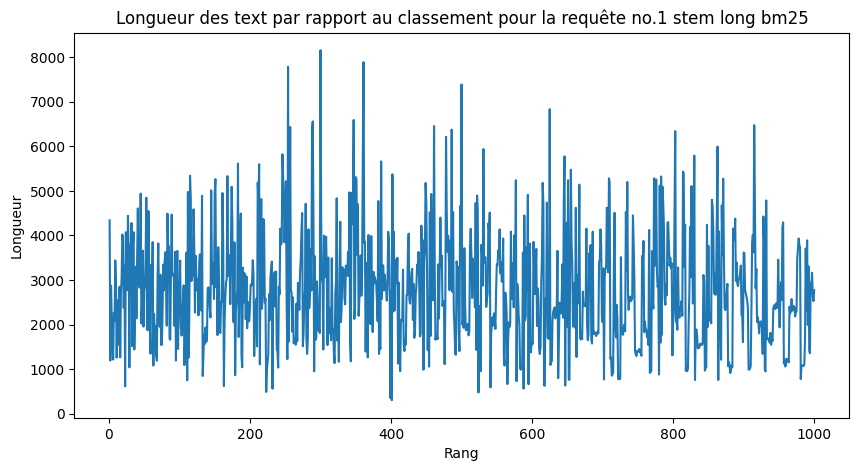

In [87]:
import matplotlib.pyplot as plt

# Assuming numbers is your array of numbers
numbers = lengths # replace with your actual numbers

# Sort numbers in descending order and generate ranks
# numbers.sort(reverse=True)
# ranks = range(1, len(numbers) + 1)

plt.figure(figsize=(10, 5))
plt.plot(ranks, numbers)
plt.xlabel('Rang')
plt.ylabel('Longueur')
plt.title('Longueur des text par rapport au classement pour la requête no.1 stem long bm25')
plt.show()

In [88]:
print(f"Found {len(hits)} hits.")
# for score_doc in hits:
score_doc = hits[0]

print(score_doc)
doc = searcher.doc(score_doc.doc)
print( doc.get("doc_id")) 
score = score_doc.score
explanation = searcher.explain(query, score_doc.doc)
print(type(doc))
# print(f"Document: {doc}, Score: {score}")
print(f"Score: {score}")
print(f"Explanation: {explanation}")

Found 1000 hits.
doc=20403 score=14.748432 shardIndex=-1
AP880502-0134
<class 'org.apache.lucene.document.Document'>
Score: 14.748432159423828
Explanation: 14.748432 = sum of:
  8.27583 = weight(content:antitrust in 20403) [BM25Similarity], result of:
    8.27583 = score(freq=5.0), computed as boost * idf * tf from:
      2.0 = boost
      5.572012 = idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:
        923 = n, number of documents containing term
        242845 = N, total number of documents with field
      0.742625 = tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:
        5.0 = freq, occurrences of term within document
        1.2 = k1, term saturation parameter
        0.75 = b, length normalization parameter
        472.0 = dl, length of field (approximate)
        296.46722 = avgdl, average length of field
  4.017544 = weight(content:pend in 20403) [BM25Similarity], result of:
    4.017544 = score(freq=2.0), computed as boost * idf * tf from:
     

In [25]:
reader.close()

### Evaluation

In [38]:
import glob
import gzip
import re

topic_pattern = re.compile(r'<top>(.*?)</top>', re.DOTALL)
# Regular expressions for individual elements
num_pattern = re.compile(r'<num>\s*Number:\s*(\d+)')
title_pattern = re.compile(r'<title>\s*Topic:\s*(.*?)\s*\n')
desc_pattern = re.compile(r'<desc>\s*Description:\s*(.*?)\s*<narr>', re.DOTALL)

def get_requests() :
    requests = []
    
    # Get a list of all topics files in the "Topics-requetes" directory
    file_list = [
       "TREC AP 88-90/TREC AP 88-90/Topics-requetes/topics.1-50.txt",
       "TREC AP 88-90/TREC AP 88-90/Topics-requetes/topics.51-100.txt",
       "TREC AP 88-90/TREC AP 88-90/Topics-requetes/topics.101-150.txt",
    ]
    # Loop over the list of files
    for filename in file_list:

        # Open the .gz file
        with open(filename, 'r') as file:
            # Read the content of the file
            topic_requests_string = file.read()
            for topic in topic_pattern.finditer(topic_requests_string):
                topic_content = topic.group(1)

                # Extracting individual elements
                topic_id = num_pattern.search(topic_content)
                title = title_pattern.search(topic_content)
                desc = desc_pattern.search(topic_content)
                
                if(topic_id) :
                    requests.append([topic_id.group(1), title.group(1) if title else None, desc.group(1).strip() if desc else None])
                    
    return requests 

def build_request(requests) :
    short_requests = []
    long_requests = []
    for request in requests :  
        # request[1] => title , request[2] => description
        short_requests.append(request[1])
        long_requests.append(request[1] + request[2])
    return (short_requests, long_requests)

from java.io import File
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import ClassicSimilarity, BM25Similarity, LMJelinekMercerSimilarity, BooleanSimilarity
from org.apache.lucene.index import  DirectoryReader
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser

def set_similirity_weight_schemat(searcher, weight_schemat) :
    if weight_schemat == "classic" : 
        searcher.setSimilarity(ClassicSimilarity())
    if weight_schemat == "bm25" : 
        searcher.setSimilarity(BM25Similarity(1.2,0.75))
    if weight_schemat == "LM" : 
        searcher.setSimilarity(LMJelinekMercerSimilarity(0.7))
    if weight_schemat == "boolean" : 
        searcher.setSimilarity(BooleanSimilarity())

def get_requests_run(queries) :
    run = []
    for index, query_string in enumerate(queries) :
        # Check if the query string is empty or consists of only whitespace
        try :
            query_string = query_string.replace("/", "").replace("?", "").replace("`", "").replace("(", "").replace(")", "")
            query = QueryParser("content", analyzer).parse(query_string)
            hits = searcher.search(query, 1000).scoreDocs

            # Check if the query has any hits
            if len(hits) == 0 :
                print("No hits found for query : ", query_string)
           
            for i,hit in enumerate(hits):
                doc = searcher.doc(hit.doc)
                run.append((index+1, "Q0", doc.get("doc_id"), i+1, hit.score, "trec_run"))
        except :
            print("Error in query : ", query_string)
            continue
    return run

def write_run_file(results, file_path):
    with open(file_path, 'w') as f:
        for result in results:
            f.write(" ".join(map(str, result)) + "\n")

In [7]:
similarity = "LM"

queries = get_requests() 
reader = DirectoryReader.open(index)
searcher = IndexSearcher(reader)
set_similirity_weight_schemat(searcher, similarity)

# build_request 
short_requests, long_requests = build_request(queries)

short_requests_run = get_requests_run(short_requests)
long_requests_run = get_requests_run(long_requests)

print(short_requests_run[0])
print(long_requests_run[0])
write_run_file(short_requests_run, "TREC AP 88-90/TREC AP 88-90/trec_runs/short_basic_" + similarity + ".run")
write_run_file(long_requests_run, "TREC AP 88-90/TREC AP 88-90/trec_runs/long_basic_" + similarity + ".run")

(1, 'Q0', 'AP890731-0265', 1, 11.58420181274414, 'trec_run')
(1, 'Q0', 'AP890731-0265', 1, 19.042831420898438, 'trec_run')


### Trec eval

In [8]:
from trectools import TrecEval, TrecQrel, TrecRun

def trec_eval(run_path, qrel_path):
    run = TrecRun(run_path)
    qrel= TrecQrel(qrel_path)
    te = TrecEval(run, qrel)

    result = {}
    result["num_ret"] = te.get_retrieved_documents(per_query=False)
    result["num_rel"] = te.get_relevant_documents(per_query=False)
    result["num_rel_ret"] = te.get_relevant_retrieved_documents(per_query=False)
    result["map"] = te.get_map(depth=1000, per_query=False, trec_eval=True) 
    for v in [5, 10, 15, 20, 30, 100, 200, 500, 1000]:
        result[f"P@{v}"] = te.get_precision(depth=v, per_query=False, trec_eval=True)

    return result

def format_res(overall_result) :
  map_values = [inner_dict['map'] for inner_dict in overall_result.values()]
  mean_map = sum(map_values) / len(map_values)
  P_10 = [inner_dict['P@10'] for inner_dict in overall_result.values()]
  mean_P_10 = sum(P_10) / len(P_10)
  # 5, 10, 15, 20, 30, 100, 200, 500, 1000
  return { 
    "MMAP" : mean_map, 
    "P@10" :mean_P_10,
    "num_ret": overall_result["1"]["num_ret"], 
    "num_rel": overall_result["1"]["num_rel"],
    "num_rel_ret" : overall_result["1"]["num_rel_ret"],
  }


### STEMME

In [115]:
long_stemme_bm25 = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_stemme_bm25.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_stemme_bm25)


{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 12365, 'map': 0.1906649454549337, 'P@5': 0.3946666666666667, 'P@10': 0.37666666666666665, 'P@15': 0.3595555555555556, 'P@20': 0.344, 'P@30': 0.3222222222222222, 'P@100': 0.2474, 'P@200': 0.19613333333333335, 'P@500': 0.12604, 'P@1000': 0.08243333333333334}


In [116]:
long_stemme_classic = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_stemme_classic.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_stemme_classic)

{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 11053, 'map': 0.14909556560447088, 'P@5': 0.2946666666666667, 'P@10': 0.2873333333333333, 'P@15': 0.2782222222222222, 'P@20': 0.2676666666666667, 'P@30': 0.2597777777777778, 'P@100': 0.20713333333333334, 'P@200': 0.1663, 'P@500': 0.10836000000000001, 'P@1000': 0.07368666666666666}


In [118]:
long_stemme_lm = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_stemme_LM.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_stemme_lm)

{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 11610, 'map': 0.17500922752299103, 'P@5': 0.376, 'P@10': 0.32666666666666666, 'P@15': 0.31155555555555553, 'P@20': 0.3053333333333333, 'P@30': 0.29111111111111115, 'P@100': 0.22753333333333334, 'P@200': 0.1801, 'P@500': 0.11737333333333334, 'P@1000': 0.07739333333333334}


In [119]:
short_stemme_bm25 = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_stemme_bm25.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_stemme_bm25)

{'num_ret': 144288, 'num_rel': 25549, 'num_rel_ret': 11488, 'map': 0.18136221076223133, 'P@5': 0.35333333333333333, 'P@10': 0.33066666666666666, 'P@15': 0.3146666666666667, 'P@20': 0.30466666666666664, 'P@30': 0.2902222222222222, 'P@100': 0.2305333333333333, 'P@200': 0.18513333333333334, 'P@500': 0.11834666666666666, 'P@1000': 0.07658}


In [120]:
short_stemme_classic = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_stemme_classic.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_stemme_classic)

{'num_ret': 144288, 'num_rel': 25549, 'num_rel_ret': 10397, 'map': 0.13537729488258624, 'P@5': 0.24666666666666667, 'P@10': 0.24400000000000002, 'P@15': 0.24177777777777776, 'P@20': 0.23433333333333337, 'P@30': 0.23155555555555557, 'P@100': 0.1864, 'P@200': 0.1539666666666667, 'P@500': 0.10250666666666668, 'P@1000': 0.06931333333333334}


In [121]:
short_stemme_lm = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_stemme_LM.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_stemme_lm)

{'num_ret': 144288, 'num_rel': 25549, 'num_rel_ret': 10977, 'map': 0.16457703092183423, 'P@5': 0.32533333333333336, 'P@10': 0.29533333333333334, 'P@15': 0.28444444444444444, 'P@20': 0.27599999999999997, 'P@30': 0.2602222222222222, 'P@100': 0.21153333333333335, 'P@200': 0.173, 'P@500': 0.11132, 'P@1000': 0.07318000000000001}


### BASIC


In [10]:
long_basic_bm25 = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_basic_bm25.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_basic_bm25)

{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 11019, 'map': 0.1668214469130914, 'P@5': 0.38666666666666666, 'P@10': 0.3513333333333334, 'P@15': 0.3342222222222222, 'P@20': 0.3203333333333333, 'P@30': 0.2988888888888889, 'P@100': 0.22446666666666668, 'P@200': 0.17503333333333332, 'P@500': 0.11262666666666665, 'P@1000': 0.07346000000000001}


In [11]:
long_basic_classic = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_basic_classic.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_basic_classic)

{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 9726, 'map': 0.12732352486635037, 'P@5': 0.27199999999999996, 'P@10': 0.26733333333333337, 'P@15': 0.26666666666666666, 'P@20': 0.25600000000000006, 'P@30': 0.24, 'P@100': 0.18420000000000003, 'P@200': 0.14673333333333333, 'P@500': 0.09694666666666668, 'P@1000': 0.06484}


In [12]:
long_basic_LM = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/long_basic_LM.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(long_basic_LM)

{'num_ret': 150000, 'num_rel': 25549, 'num_rel_ret': 10385, 'map': 0.14989938727803764, 'P@5': 0.3466666666666667, 'P@10': 0.31533333333333335, 'P@15': 0.3008888888888888, 'P@20': 0.28433333333333327, 'P@30': 0.26844444444444443, 'P@100': 0.205, 'P@200': 0.15983333333333336, 'P@500': 0.10476000000000002, 'P@1000': 0.06923333333333333}


In [14]:
short_basic_bm25 = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_basic_bm25.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_basic_bm25)

{'num_ret': 143631, 'num_rel': 25549, 'num_rel_ret': 10062, 'map': 0.15695876880382706, 'P@5': 0.33866666666666667, 'P@10': 0.31333333333333335, 'P@15': 0.29777777777777775, 'P@20': 0.285, 'P@30': 0.27, 'P@100': 0.20693333333333333, 'P@200': 0.16133333333333333, 'P@500': 0.10196000000000001, 'P@1000': 0.06708000000000001}


In [15]:
short_basic_classic = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_basic_classic.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_basic_classic)

{'num_ret': 143631, 'num_rel': 25549, 'num_rel_ret': 9045, 'map': 0.1130943997839862, 'P@5': 0.20800000000000002, 'P@10': 0.21733333333333335, 'P@15': 0.21244444444444444, 'P@20': 0.21333333333333335, 'P@30': 0.212, 'P@100': 0.16706666666666667, 'P@200': 0.13453333333333334, 'P@500': 0.08845333333333334, 'P@1000': 0.06029333333333334}


In [16]:
short_basic_LM = trec_eval("TREC AP 88-90/TREC AP 88-90/trec_runs/short_basic_LM.run", "TREC AP 88-90/TREC AP 88-90/jugements de pertinence/qrels.1-150-AP8890.txt")
print(short_basic_LM)

{'num_ret': 143631, 'num_rel': 25549, 'num_rel_ret': 9435, 'map': 0.13894211367637874, 'P@5': 0.30533333333333335, 'P@10': 0.28, 'P@15': 0.26844444444444443, 'P@20': 0.25933333333333325, 'P@30': 0.2451111111111111, 'P@100': 0.19173333333333334, 'P@200': 0.15093333333333334, 'P@500': 0.09462666666666666, 'P@1000': 0.06289333333333333}
